In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.table import Table
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from reproject import reproject_interp
import matplotlib.cm as cm
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
t = Table.read('grg_table.fits')
mosaic_name = 'mosaic.fits'
mosaic = fits.open(mosaic_name)[0]
grglist = Table.read('grg-list.txt',format='ascii')
wise_name = grglist['wise_image']
names = []
obj = []
names = grglist['name']
obj=[]
for i in range(0,63):
    x = names[i].split(',')[0]
    obj.append(x)

In [4]:
def find_noise(a):
    b=a.flatten()
    for i in range(10):
        m=np.nanmean(b)
        s=np.nanstd(b)
        b=b[b<(m+5.0*s)]
    return m,s

In [ ]:
def find_noise_area(hdu,ra,dec,size):
    # ra, dec, size in degrees
    ysize,xsize=hdu[0].data.shape
    w=WCS(hdu[0].header)
    ras=[ra-size,ra-size,ra+size,ra+size]
    decs=[dec-size,dec+size,dec-size,dec+size]
    xv=[]
    yv=[]
    for r,d in zip(ras,decs):
        x,y=w.wcs_world2pix(r,d,0)
        xv.append(x)
        yv.append(y)
    xmin=int(min(xv))
    if xmin<0: xmin=0
    xmax=int(max(xv))
    if xmax>=xsize: xmax=xsize-1
    ymin=int(min(yv))
    if ymin<0: ymin=0
    ymax=int(max(yv))
    if ymax>=ysize: ymax=ysize-1
    subim=hdu[0].data[ymin:ymax,xmin:xmax]
    mean,noise=find_noise(subim)
    for i in range(5,0,-1):
        vmax=np.nanmedian(subim[subim>(mean+i*noise)])
        if not(np.isnan(vmax)):
            break
    return mean,noise,vmax

In [7]:
def GRG(RA,DEC,H_RA,H_DEC,wise,z,output,title):
    Source = {
        'RA' : RA,
        'DEC' : DEC,
        'PixelRes' : 0.00011
    }

    c = SkyCoord(Source['RA'], Source['DEC'], frame='icrs')

    nax = 600
    
    wcs_input_dict = {
       'CTYPE1': 'RA---TAN',
       'CUNIT1': 'deg',
       'CDELT1': -Source['PixelRes'],
       'CRPIX1': nax,
       'CRVAL1': c.ra.deg,
       'NAXIS1': 2*nax,
       'CTYPE2': 'DEC--TAN',
       'CUNIT2': 'deg',
       'CDELT2': Source['PixelRes'],
       'CRPIX2': nax,
       'CRVAL2': c.dec.deg,
       'NAXIS2': 2*nax
   }
    
    wcs_my = WCS(wcs_input_dict)
    
    wise_file = wise
    wise_img = fits.open(wise_file)[0]
    wise_reproj = reproject_interp( wise_img, wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )
    grg_reproj = reproject_interp( mosaic, wcs_my, shape_out=[2*nax,2*nax], return_footprint=False )
    
    wcs_mosaic = WCS(mosaic.header, naxis= 2)
    wcs_wise = WCS(wise_img.header, naxis= 2)
    
    rms = find_noise(grg_reproj)[1]/1.2            # noise level in image cutout
    lc = 2.0 * rms        # lowest contour level 
    sep = np.sqrt(2.0)    # separation of contour levels
    levels = rms * 3.0 * 2**np.linspace(0,15,40) # generates a sequence of contour levels
    
    vmax = np.nanmax(grg_reproj)

    plt.clf()
    fig = plt.figure(figsize=(8,8))
    ax = plt.subplot(projection = wcs_my)
    
    ax.imshow(wise_reproj.data, origin = 'lower',cmap =cm.binary )
    ax.contourf(grg_reproj.data, levels=levels, cmap=cm.viridis ,alpha=0.6,vmax =vmax)
    ax.scatter(H_RA,H_DEC,transform=ax.get_transform('icrs'),marker='X',c='red',s=70, edgecolors='white')
    
    ax.tick_params(axis='both', labelsize=20)
    ax.set_xlabel('Right Ascension', fontsize=20)
    ax.set_ylabel('Declination',fontsize=20)
    ax.set_title(title,fontsize=20)
    
    BarLength_kpc = 500 * u.kpc
    redshift = z
    kpc_proper_per_arcmin = cosmo.kpc_proper_per_arcmin(redshift)
    BarLength_degree = ( BarLength_kpc / kpc_proper_per_arcmin ).to(u.degree)
    BarLength_pixel = BarLength_degree / ( Source['PixelRes'] * u.degree )
    print(BarLength_pixel)
    ax.plot( [2*nax-20-BarLength_pixel,2*nax-20], [20, 20], '-', lw=5, color='black')
    plt.text( 2*nax-20-BarLength_pixel/2, 30,  '500 kpc (z=%.3f)'%(redshift),horizontalalignment='center', color='black', fontsize=12 )
    
    plt.savefig(output,bbox_inches="tight")

338.91998790506995


<Figure size 432x288 with 0 Axes>

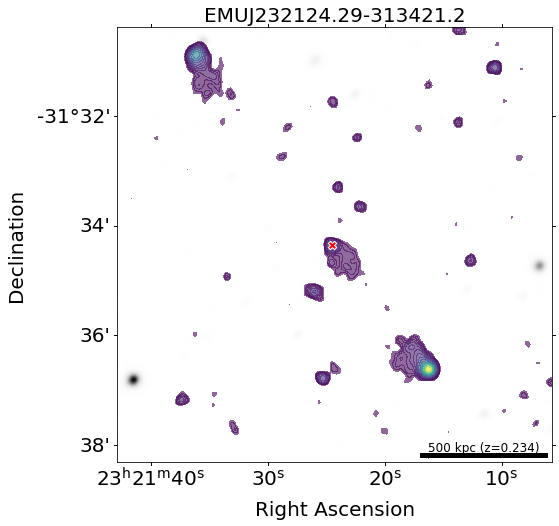

In [8]:
for i in range(33,34):
    RA = t[i]['RA'] * u.deg
    DEC = t[i]['DEC'] * u.deg
    H_RA = t[i]['Host_RA'] * u.deg
    H_DEC = t[i]['Host_DEC'] * u.deg
    w_name = wise_name[i]
    z = t['zfinal_new'][i]
    size = 0.02 * u.deg
    title = obj[i]
    img_name = 'GRG_IMG_'+ str(i) +'.png'
    GRG(RA,DEC,H_RA,H_DEC,w_name,z,img_name,title)